# Reinforcement Learning


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
import time


Today we will look at reinforcement learning.

To recap, supervised learning attempts to understand some relationship between a
set of features, $X$, and a labeled target, $Y$, and unsupervised learning
attempts to understand some relationship between a set of data points described
only by the features $X$.

Unlike those techniques, reinforcement learning tries to understand the
relationship between taking certain actions, and the consequences of those
actions. The simplest example for employment of reinforcement learning is within
games like chess. Every action has a potential consequence, but a set of actions
can only have good consequences further in time, so how do we train a system to
study the relationship between actions and potential consequences?


## Exploration-exploitation strategies


In reinforcement learning, the choice of an action is usually driven by two
distinct goals: either to explore the environment and potential rewards to our
actions, or to exploit what we learned so far. These could be two well-separated
phases in the algorithm or somewhat interleaved steps.

1. In the _exploration_ steps, our goal is not to maximize profits in the short
   term, but instead to discover the strategy which will maximize profits in the
   long term. In other words, we want to establish a relationship between our
   **actions** and their associated **reward**.

2. _The exploitation_ steps are where we apply the best method found in the
   exploration phase, hopefully maximizing long term profits. We pick the
   **action** which produces the highest **reward**, and we perform this action
   as much as we can.


Of course, every trial in the exploration phase is potentially costing us money
in a real-world scenario. So, how do we discover which is the most profitable
and how do we do so with the least cost. The first such example we look at is
known as the multi-arm bandit problem.


## Multi-Armed Bandit Problem


<img src = "https://drive.google.com/uc?export=view&id=1Iin2VKiGHU9sSWcp1w7WMjTrSP_4HdFe" width = 400>
<center><i>(Image Source: <a>https://upload.wikimedia.org/wikipedia/commons/3/34/Slot_machines_at_Wookey_Hole_Caves.JPG</a>)</i></center>

The name is inspired by casino slot machines, each of which has an arm we pull
to play (action), each machine has a different payout (different reward), and
our job as gamblers is to discover which machine leads to the highest profits
(while spending as little money as possible).


From a theoretical perspective, a multi-arm bandit is made up of $k$ machines
(or options). We can describe their mean payouts with the array:

$$(\mu_1,\mu_2,\cdots ,\mu_k)$$

We don't know these means, we won't even assume we have a prior belief over
them. Our goal is to use exploration to find the machine with the highest mean
and then exploit this knowledge for our gain.


Generally, any reinforcement learning algorithm is composed of an **agent**
<img src = "https://drive.google.com/uc?export=view&id=190ZAOG_E8xbF_Vi_IVmGN7NXgo_6jKQ7" width = 100>

<center><i>(Image Source: <a>https://storage.needpix.com/rsynced_images/agent-1626306_1280.png</a>)</i></center>

which tries to learn a set of **actions** and navigate between **states** by
studying the **rewards** different actions (or sequences of actions) produce.


### $\epsilon-Greedy$

As a first strategy we will employ what is known as $\epsilon-Greedy$. This
strategy doesn't have separate exploration/exploitation phase. Instead it
alternates between the two. The algorithm runs trials one after another, after
each trial it makes an estimate of the outcome means
$(\mu_1',\mu_2',\cdots ,\mu_k')$.

For each new trial, the algorithm will either execute an exploration or
exploitation step:

- In an exploration trial we select one of the $k$ options (**actions**)
  uniformly at random, if we selected option $i$ we pull the arm on machine $i$,
  see its recent payout (**reward**), and then we update our estimate of $\mu_i$
  by updating $\mu_i'$.

- In an exploitation trial, we also select a machine and pull its arm, but we
  don't select at random. Rather we select the machine whose current estimated
  $\mu$ is the highest.

How do we decide which method to use at each trial? We use the $\epsilon$
parameter which is between 0 and 1. We run an exploration trial with probability
$\epsilon$, otherwise (with probability $1-\epsilon$) we execute an exploitation
trial.


---

Let's run through an example. Imagine we had the following machines:


In [3]:
machine_means = np.array([0.2, 0.3, 0.5, 0.2, 0.9])
machines = pd.DataFrame(
    {
        "Machine Name": ["Machine " + str(i) for i in range(5)],
        "True Means": machine_means,
        "Number of Runs": np.array([0.0, 0.0, 0.0, 0.0, 0.0]),
        "Total Payout": np.array([0.0, 0.0, 0.0, 0.0, 0.0]),
        "Estimated Means": np.array([0.0, 0.0, 0.0, 0.0, 0.0]),
    }
)
machines


,Machine Name,True Means,Number of Runs,Total Payout,Estimated Means
0,Machine 0,0.2,0.0,0.0,0.0
1,Machine 1,0.3,0.0,0.0,0.0
2,Machine 2,0.5,0.0,0.0,0.0
3,Machine 3,0.2,0.0,0.0,0.0
4,Machine 4,0.9,0.0,0.0,0.0


Each machine has a different payout. We know the real values here since we
created these machines, but we will pretend our agent doesn't know them. We will
now run an $\epsilon$-greedy algorithm


In [4]:
# random coin flip
np.random.binomial(1, 0.5, 1)[0]


1

In [5]:
def epsilon_greedy(epsilon, machines_df):
    """
    Parameters:
    epsilon: float between 0 and 1, fraction of steps for exploration
    machines_df: bookkeeping dataframe of machines and previous games

    Output: updated bookkeeping dataframe after one action
    """

    # Determine if this is an explore/exploit trial - biased coin flip
    epsilon_coin = np.random.binomial(1, epsilon, 1)[0]

    # Explore trial
    if (epsilon_coin == 1) or (np.sum(machines_df["Estimated Means"]) == 0.0):

        # choose a machine at random
        choice = np.random.randint(machines_df.shape[0])

    # Exploit trial
    else:

        # choose the best machine
        choice = np.argmax(machines_df["Estimated Means"])

    # Pull the machine of choice and update our payouts and estimated means
    trial_result = np.random.binomial(1, machines_df.loc[choice, "True Means"], 1)[0]

    # same with a deterministic reward if you add a Reward column
    # trial_result = machines_df.loc[choice, "Reward"]

    # update the bookkeeping
    machines_df.loc[choice, "Number of Runs"] += 1
    machines_df.loc[choice, "Total Payout"] += trial_result
    machines_df.loc[choice, "Estimated Means"] = (
        machines_df.loc[choice, "Total Payout"] / machines_df.loc[choice, "Number of Runs"]
    )

    # return the updated estimated means
    return machines_df


If we were to run this strategy with five machines for 10,000 trials


In [7]:
num_trials = 10000
epsilon = 0.1  # 10% of the time, we explore

for i in range(num_trials):
    print(f"Running Trial {i}", end="\r")
    machines = epsilon_greedy(epsilon, machines)
#     if i % 1000 == 0:
#         print(machines)

machines


,Machine Name,True Means,Number of Runs,Total Payout,Estimated Means
0,Machine 0,0.2,1983.0,407.0,0.205245
1,Machine 1,0.3,1994.0,597.0,0.299398
2,Machine 2,0.5,2040.0,1024.0,0.501961
3,Machine 3,0.2,2002.0,412.0,0.205794
4,Machine 4,0.9,11981.0,10755.0,0.897671


You can consider $\epsilon$ as a hyperparameter: some amount of exploration is
good but too much will unnecessarily pick actions that we already know don't
work.


In [8]:
machines["Total Payout"].sum()


13195.0

First, notice that the estimated means are pretty close to the true means, so
the strategy has learned what the machine payouts are. But is the strategy a
profitable one?

The measure of profit in the multi-arm bandit setting is called _regret
minimization_. Regret is the difference between the best we could have had (in
expectation) and what we actually got. What is the best possible outcome? In
this particular example the best strategy is to always pick the machine with the
highest mean ($\mu_{opt}$). So after $T$ rounds the optimal strategy would pay
us $T \cdot \mu_{opt}$ in expectation, instead by picking machine $i$ in round
$j$ we got payment $p_j^i$. So after $T$ rounds our overall regret is:

$$T \cdot \mu_{opt} - \sum_{j=1}^T p_j^i$$

We can calculate this with the following function:


In [9]:
def regret(machine_df):
    optimal_machine = np.max(machine_df["True Means"])
    trial_number = np.sum(machine_df["Number of Runs"])

    optimal_payout = trial_number * optimal_machine
    actual_payout = np.sum(machine_df["Total Payout"])
    return optimal_payout - actual_payout


And get the overall regret of our strategy with the following call:


In [10]:
print(f"Total Regret: {regret(machines)}")


Total Regret: 4805.0


Is this regret good or bad? It's hard to say. To use regret we should compare it
against other strategies and try to find the one with the overall minimal
regret.

One problem with the regret measure is it require that we know what the overall
optimal machine is. Obviously if we knew this we would not require an
exploration phase. Instead when calculating regret we can make an estimate of
the optimal, using the knowledge we've accumulated.


---
#### Exercise 1

1. Implement regret in each round of the $\epsilon-Greedy$ strategy. That is,
augment our the code in the function above so that we record the regret of the
strategy after every move. Plot the round by round regret of this strategy.
---


#### Solution


We will record the (cumulative) regret over the game and then plot the results:


In [14]:
# reset the bookkeeping dataframe
machine_means = np.array([0.2, 0.3, 0.5, 0.2, 0.9])
machines = pd.DataFrame(
    {
        "Machine Name": ["Machine " + str(i) for i in range(5)],
        "True Means": machine_means,
        "Number of Runs": np.array([0.0, 0.0, 0.0, 0.0, 0.0]),
        "Total Payout": np.array([0.0, 0.0, 0.0, 0.0, 0.0]),
        "Estimated Means": np.array([0.0, 0.0, 0.0, 0.0, 0.0]),
    }
)

# trial runs
num_trials = 10000
epsilon = 0.1  # 10% of the time, we explore

regrets = []
for i in range(num_trials):
    print(f"Running Trial {i}", end="\r")
    machines = epsilon_greedy(epsilon, machines)

    # calculate regret
    current_regret = regret(machines)

    # save regret
    regrets.append(current_regret)


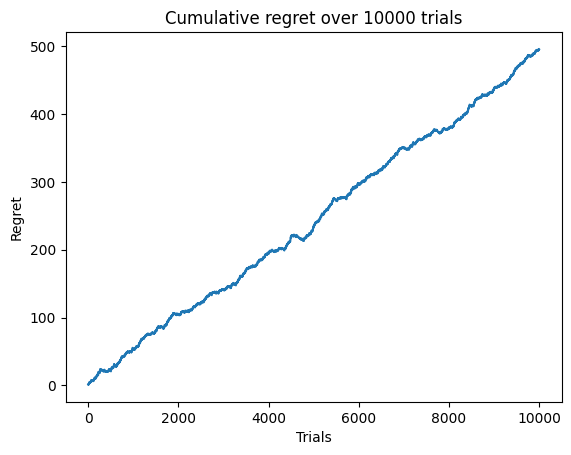

In [15]:
plt.figure()
plt.plot(range(num_trials), regrets)
plt.xlabel("Trials")
plt.ylabel("Regret")
plt.title("Cumulative regret over 10000 trials")
plt.show()


In [13]:
machines


,Machine Name,True Means,Number of Runs,Total Payout,Estimated Means
0,Machine 0,0.2,188.0,40.0,0.212766
1,Machine 1,0.3,209.0,64.0,0.306220
2,Machine 2,0.5,205.0,107.0,0.521951
3,Machine 3,0.2,187.0,27.0,0.144385
4,Machine 4,0.9,9211.0,8286.0,0.899577


We can see how initially the regret grew much more steeply but as we learned the
optimal strategy to choose the best machine (in the first few hundred games) the
growth rate stabilized. Note that the regret keeps growing because we still play
non-optimally in the exploration phase 10% of the time.


### $\epsilon-Decay$ Strategy

As mentioned above, we usually have multple strategies that we compare using
regret.

$\epsilon-Decay$ is pretty much the same as $\epsilon-Greedy$, except we start
with a higher $\epsilon$ and slowly decrease it over time.

We usually try various decay techniques, such as
$\epsilon_{new} = \epsilon_{old} - c$ or
$\epsilon_{new} = \frac{\epsilon_{old}}{c}$. We then compare the regret over
time of new strategies (along with the original $\epsilon-Greedy$) in order to
select the best strategy.


### Actions and Rewards

Looking at the information we've collected while running our epsilon greedy
algorithm, we can look at two columns: The machine, and its associated payout


In [16]:
machines[["Machine Name", "Estimated Means"]]


,Machine Name,Estimated Means
0,Machine 0,0.175926
1,Machine 1,0.335052
2,Machine 2,0.544554
3,Machine 3,0.199005
4,Machine 4,0.898117


and we can re-frame these information pieces as **actions** and **rewards**.


In [17]:
new_df = machines[["Machine Name", "Estimated Means"]].copy()
new_df.columns = ["Action", "Reward"]
new_df


,Action,Reward
0,Machine 0,0.188172
1,Machine 1,0.287938
2,Machine 2,0.496503
3,Machine 3,0.169014
4,Machine 4,0.898764


Notice in terms of information, we really have a $5 \times 1$ information vector
which says that whenever we take action $i$ we get reward $reward[i]$, then we
are thrown back into the same **state** to choose which machine to pull again.

In this setup, we of course will always pull machine 4... but what if we had a
slightly unusual set-up where we can't pull the same machine twice in a row? Now
we might pull machine 4's arm, and get our reward, but we cannot do it again. We
are in a new **state** and our available choices are different than they were
one turn ago.


## Markov Decision Processes

Multi-armed bandits are a special case of Markov Decision Processes (MDPs). In
an MDP the world is divided into a set of states $S$, each state $s \in S$ has a
set of actions $A_s$, an action $a \in A_s$ transitions us from state $s$ to
some other state $s'$ and the action has some (possibly random) reward $R_a$.

The multi-armed bandit is a MDP with one state, the actions, lever pulls, lead
back to the same state. In general MDPs can be far more complex:

<img src = "https://drive.google.com/uc?export=view&id=1G894t7UGZdNnDIzwQDUrRz7s7-2V7gAo"  width = 500>
<center><i>(Image Source: <a>https://upload.wikimedia.org/wikipedia/commons/2/21/Markov_Decision_Process_example.png</a>)</i></center>

Our goal with MDPs is the same as our goal with multi arm bandit. We need to
explore the system and discover the structure and payments of the systems and
exploit this knowledge to maximize our payouts. Critically we do not know
anything about the structure of the MDP a priori, we must discover this through
exploration.


## Q-Learning

Since the 1980s the standard way for dealing with MDPs has been the Q-Learning
algorithm. Q-Learning, shorthand for Quality Function Learning, is a general
methodology for learning the payment structure of the MDP. It learns to
associate with every state $s$, and an action (accessible from the state) $a$, a
quality score $Q(s,a)$. $Q(s,a)$ is meant to approximate the quality of the
outcome taking action $a$ at state $s$ will eventually lead to.

If we knew the structure of the MDP we could easily take the optimal path
through the states minimizing our cost (equivalently maximizing our reward). But
since we don't know what structure looks like, connections or payments, we need
to explore and learn which paths lead to good outcomes, that is we need to learn
the $Q$ function via exploration. With a good Q-Function we can exploit our
knowledge and maximize our profits.


At the core of the Q-Learning algorithm is a Q-table; A table which stores
information about the world as experienced by an agent (in the Multi-armed
Bandit, we had an automatic agent populating a $5\times 1$ Q-table). Let's
imagine we have a world of a $3\times 3$ tiles, and an agent which has several
actions available: move up, move down, move left, and move right.


<table>
    <tr>
        <th>            
        </th>
        <th>
            Up
        </th>
        <th>
            Down
        </th>
        <th>
            Left
        </th>
        <th>
            Right
        </th>
    </tr>
    <tr>
        <th>
            Upper Left
        </th>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>        
    </tr>
    <tr>
        <th>
            Upper Middle
        </th>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>        
    </tr>
    <tr>
        <th>
            Upper Right
        </th>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>        
    </tr>
    <tr>
        <th>
            Middle Left
        </th>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>        
    </tr>
    <tr>
        <th>
            Middle Middle
        </th>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>        
    </tr>
    <tr>
        <th>
            Middle Right
        </th>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>        
    </tr>
    <tr>
        <th>
            Bottom Left
        </th>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>        
    </tr>
    <tr>
        <th>
            Bottom Middle
        </th>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>        
    </tr>
    <tr>
        <th>
            Bottom Right
        </th>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>
        <td>  
            0.0
        </td>        
    </tr>
</table>


Which we can represent as a matrix:

$$
Q\_table = \begin{bmatrix} 0.0 & 0.0 & 0.0 & 0.0 \\
                            0.0 & 0.0 & 0.0 & 0.0 \\
                            0.0 & 0.0 & 0.0 & 0.0 \\
                            0.0 & 0.0 & 0.0 & 0.0 \\
                            0.0 & 0.0 & 0.0 & 0.0 \\
                            0.0 & 0.0 & 0.0 & 0.0 \\
                            0.0 & 0.0 & 0.0 & 0.0 \\
                            0.0 & 0.0 & 0.0 & 0.0 \\
                            0.0 & 0.0 & 0.0 & 0.0 \\\end{bmatrix}
$$


Of course it starts out as all zeros because our agent knows nothing about the
world. Now let's say our agent makes an action, receives some reward, and now
has to update its understanding of the world, how would it update its
understanding?

The agent updates its understanding based on the following rule called Bellman's
equation:

$$Q_{new}(s,a) = (1-\alpha) \cdot Q_{old}(s,a) + \alpha \cdot (r + \gamma  (max_{a'}Q(s',a'))$$

Where: <br>

- $\alpha$ is the learning rate that controls how fast the Q-values are changing
  (the smaller $\alpha$ is, the slower the change), <br>
- $r$ is the reward received for performing action $a$ in state $s$, <br>
- $\gamma$ is a discount parameter which determines how much it discounts future
  rewards when making the update,<br>
- $max_{a'}Q(s',a')$ is the maximum $Q$ value from the new state we move into.
  In essence, the agent looks ahead and asks "if I take the action to take me
  into state $s'$, what is the highest reward I can get there?"

Notice that if $\gamma = 0$, then the rule becomes
$$Q_{new}(s,a) = (1-\alpha)\cdot Q_{old}(s,a) + \alpha\cdot r$$ which means we
only take into account the immediate reward we just got.


Python has a `Turtle` module that has been expanded to jupyter notebooks, let's
employ it to illustrate Q-learning.


In [20]:
from turtleScript import *

# A few parameters to intialize

tile_number = 3
t = QTurtle(TILE_NUMBER=tile_number)
display(t)
t.reset_world()


ModuleNotFoundError: No module named '_tkinter'

Our turtle here is the agent, and let's pretend there is food on the bottom
right square. We want to teach our turtle that it should move towards there. How
will that work?

Let's begin with an empty Q-table, it will have $tile\_number^2 \times 4$
entries. 4 entries of up,down, left, and right for each square on the board.
Let's also create a representation of the world, with some big reward in the
bottom right square


In [19]:
World = np.zeros((tile_number, tile_number))
World[-1, -1] = 100
display(World)


array([[  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0., 100.]])

In [20]:
Q_table = pd.DataFrame(
    columns=["Up", "Down", "Left", "Right"],
    index=[
        "Top Left",
        "Top Middle",
        "Top Right",
        "Middle Left",
        "Middle Middle",
        "Middle Right",
        "Bottom Left",
        "Bottom Middle",
        "Bottom Right",
    ],
    data=np.zeros((tile_number * tile_number, 4)),
)
display(Q_table)


,Up,Down,Left,Right
Top Left,0.0,0.0,0.0,0.0
Top Middle,0.0,0.0,0.0,0.0
Top Right,0.0,0.0,0.0,0.0
Middle Left,0.0,0.0,0.0,0.0
Middle Middle,0.0,0.0,0.0,0.0
Middle Right,0.0,0.0,0.0,0.0
Bottom Left,0.0,0.0,0.0,0.0
Bottom Middle,0.0,0.0,0.0,0.0
Bottom Right,0.0,0.0,0.0,0.0


Now let's make our turtle move one square right, and one square down


In [21]:
state = t.get_Q_state()
print(f"state was: {state}")
t.move_right()


state was: 4


Nothing to update here, we got no reward.


In [22]:
state = t.get_Q_state()
print(f"state was: {state}")
t.move_down()


state was: 5


Now let's update the Q-table, we want to update the value of the middle
rightmost square so we know the best action from that place is going straight
down.

We've yet to set our Q-learning parameters so let's do that:


In [23]:
alpha = 0.1  # learning rate parameter, how fast are we adjusting the Q-values
gamma = 0.9  # discount parameter, how much we take the future rewards account


And now apply the rule
$Q_{new}(s,a) = (1-\alpha) \cdot Q_{old}(s,a) + \alpha \cdot (r + \gamma  (max_{a'}Q(s',a'))$


In [24]:
new_state = t.get_Q_state()
print(f" New state is: {new_state}")
reward = World[-1, -1]  # 100

Q_table.iloc[state].loc["Down"] = ((1 - alpha) * Q_table.iloc[state].loc["Down"]) + (
    alpha * (reward + (gamma * np.max(Q_table.iloc[new_state])))
)


 New state is: 8


In [25]:
display(Q_table)


,Up,Down,Left,Right
Top Left,0.0,0.0,0.0,0.0
Top Middle,0.0,0.0,0.0,0.0
Top Right,0.0,0.0,0.0,0.0
Middle Left,0.0,0.0,0.0,0.0
Middle Middle,0.0,0.0,0.0,0.0
Middle Right,0.0,10.0,0.0,0.0
Bottom Left,0.0,0.0,0.0,0.0
Bottom Middle,0.0,0.0,0.0,0.0
Bottom Right,0.0,0.0,0.0,0.0


Notice how the quality of going down from state "Middle Right" has changed from
0 to 10. Now when getting to state 5 (the rightmost middle row tile) the agent
will know its best bet is to go down.

But wait, will it just randomly wander until it reaches only adjacent tiles?

Luckily no. Let's see what happens when our agent begins in the top right corner


In [26]:
t.drop_in_cell(0, 2)


In [27]:
# Inspect the Q-table
display(Q_table)


,Up,Down,Left,Right
Top Left,0.0,0.0,0.0,0.0
Top Middle,0.0,0.0,0.0,0.0
Top Right,0.0,0.0,0.0,0.0
Middle Left,0.0,0.0,0.0,0.0
Middle Middle,0.0,0.0,0.0,0.0
Middle Right,0.0,10.0,0.0,0.0
Bottom Left,0.0,0.0,0.0,0.0
Bottom Middle,0.0,0.0,0.0,0.0
Bottom Right,0.0,0.0,0.0,0.0


In [28]:
state = t.get_Q_state()
print(f"state was: {state}")
t.move_down()


state was: 2


Now we update our Q-table again. Notice our agent gets no reward from moving
down, BUT its new state says there is a reward for being in this new square


In [29]:
new_state = t.get_Q_state()
print(f"New state is: {new_state}")
print(f"state was: {state}")
turtle_row, turtle_column = t.get_cell()
reward = World[turtle_row, turtle_column]

Q_table.iloc[state].loc["Down"] = ((1 - alpha) * Q_table.iloc[state].loc["Down"]) + (
    alpha * (reward + (gamma * np.max(Q_table.iloc[new_state])))
)


New state is: 5
state was: 2


Let's break down every part of this new update. First, the old value
$(1-\alpha) \cdot Q_{old}(s,a)$ is pretty clear, it's the previous value of that
state, action pair.

Next, the reward portion $r$. What is the value of that?


In [30]:
print("reward = ", reward)


reward =  0.0


There was no reward associated with going to the middle right square, there is
no food there.

However, what about the third piece, the discounted reward
$\gamma  (max_{a'}Q(s',a')$?


In [31]:
print("New state actions' qualities:\n", Q_table.iloc[new_state], end="\n\n")
print("Best new state action quality:\n", np.max(Q_table.iloc[new_state]), end="\n\n")
print("Best new state action quality discounted:\n", gamma * np.max(Q_table.iloc[new_state]))


New state actions' qualities:
 Up        0.0
Down     10.0
Left      0.0
Right     0.0
Name: Middle Right, dtype: float64

Best new state action quality:
 10.0

Best new state action quality discounted:
 9.0


So our new value for $$\alpha \cdot (r + \gamma  (max_{a'}Q(s',a'))$$ is
$$0.1 \cdot (0.0 + 0.9 \cdot 10.0) = 0.9$$


In [32]:
display(Q_table)


,Up,Down,Left,Right
Top Left,0.0,0.0,0.0,0.0
Top Middle,0.0,0.0,0.0,0.0
Top Right,0.0,0.9,0.0,0.0
Middle Left,0.0,0.0,0.0,0.0
Middle Middle,0.0,0.0,0.0,0.0
Middle Right,0.0,10.0,0.0,0.0
Bottom Left,0.0,0.0,0.0,0.0
Bottom Middle,0.0,0.0,0.0,0.0
Bottom Right,0.0,0.0,0.0,0.0


Notice how for state "Top Right", there is now a small value associated with
going down. Why? because the quality of the cell right below it is very high
(since one cell further down is the reward, food).


### Fast forward the process...

Let's move this process further along. Let's land the turtle at random
positions, and use an epsilon greedy approach for learning about the world.


In [33]:
def epsilon_greedy_turtle(epsilon, turtle, Q_table, World):

    epsilon_coin = np.random.binomial(1, epsilon, 1)[0]

    directions = [turtle.move_up, turtle.move_down, turtle.move_left, turtle.move_right]

    state = turtle.get_Q_state()
    direction = None
    # Explore trial
    if epsilon_coin == 1:

        direction = np.random.randint(len(directions))

    # Exploit trial
    else:

        direction = np.argmax(Q_table.iloc[state].values)

    movement_function = directions[direction]  # this is a callable function
    movement_function()

    turtle_row, turtle_column = turtle.get_cell()
    new_state = t.get_Q_state()
    reward = World[turtle_row, turtle_column]

    Q_table.iloc[state, direction] = ((1 - alpha) * Q_table.iloc[state, direction]) + (
        alpha * (reward + (gamma * np.max(Q_table.iloc[new_state])))
    )

    # return the updated table
    return Q_table


We are running 500 update steps with the grid environment and the Q-table. At
the end of each episode (after we got the reward), we drop the turtle at a
random start position (`exploring starts`).


In [34]:
import time

np.random.seed(0)

step_number = 0
epsilon = 0.5
loop_number = 500
for i in range(loop_number):
    turtle_row, turtle_column = t.get_cell()
    if World[turtle_row, turtle_column] == 100.0:

        # If the turtle found food, reset it and throw it into a random new position

        random_row = np.random.randint(World.shape[0])
        random_column = np.random.randint(World.shape[1])
        step_number = 0
        t.drop_in_cell(random_row, random_column)
        time.sleep(1)
    else:
        # If it didn't find food, keep searching and learning

        step_number += 1
        Q_table = epsilon_greedy_turtle(epsilon, t, Q_table, World)
    print(f"finished {i*100/loop_number}% of run", end="\r")


In [35]:
display(Q_table)


,Up,Down,Left,Right
Top Left,10.425453,7.626582,2.010414,38.943865
Top Middle,18.584538,19.824016,5.752503,67.426614
Top Right,35.789917,87.227449,25.881357,35.492692
Middle Left,10.443475,0.000720,4.162011,47.004587
Middle Middle,20.506167,15.816151,11.498423,77.949370
Middle Right,43.278584,99.854442,22.343547,62.608747
Bottom Left,16.378020,0.000000,0.574152,3.095100
Bottom Middle,0.000000,4.217031,2.021887,52.170310
Bottom Right,0.000000,0.000000,0.000000,0.000000


In [36]:
epsilon = 0.001  # Really not likely to explore, only exploit (i.e. only follow the best path)

loop_number = 100
for i in range(loop_number):
    turtle_row, turtle_column = t.get_cell()
    if World[turtle_row, turtle_column] == 100.0:
        random_row = np.random.randint(World.shape[0])
        random_column = np.random.randint(World.shape[1])
        t.drop_in_cell(random_row, random_column)
        time.sleep(1)
    else:

        Q_table = epsilon_greedy_turtle(epsilon, t, Q_table, World)

    print(f"finished {i*100/loop_number}% of run", end="\r")


---
#### Exercise 2

1. The way we set up our reward system, our agent might not learn the shortest
path to the food from every point. Try dropping the turtle in cell (2,0) to see
how it moves towards the food. How can we modify our reward system to make it
more likely it learns the shortest path from every point?
---


#### Solution

We start by setting up an empty Q-table:


In [39]:
Q_table = pd.DataFrame(
    columns=["Up", "Down", "Left", "Right"],
    index=[
        "Top Left",
        "Top Middle",
        "Top Right",
        "Middle Left",
        "Middle Middle",
        "Middle Right",
        "Bottom Left",
        "Bottom Middle",
        "Bottom Right",
    ],
    data=np.zeros((tile_number * tile_number, 4)),
)
display(Q_table)


,Up,Down,Left,Right
Top Left,0.0,0.0,0.0,0.0
Top Middle,0.0,0.0,0.0,0.0
Top Right,0.0,0.0,0.0,0.0
Middle Left,0.0,0.0,0.0,0.0
Middle Middle,0.0,0.0,0.0,0.0
Middle Right,0.0,0.0,0.0,0.0
Bottom Left,0.0,0.0,0.0,0.0
Bottom Middle,0.0,0.0,0.0,0.0
Bottom Right,0.0,0.0,0.0,0.0


In order to optimize for a shortest path, we will give a negative reward for
stepping on any of the non-final positions (the value -10 was chosen quite
arbitrarily):


In [40]:
World


array([[  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [  0.,   0., 100.]])

In [41]:
new_World = np.where(World == 0, -10, World)
new_World


array([[-10., -10., -10.],
       [-10., -10., -10.],
       [-10., -10., 100.]])

Now, we can rerun the training loop and see how the learned Q-values and paths
changed:


In [42]:
import time

np.random.seed(0)

step_number = 0
epsilon = 0.5
loop_number = 500
for i in range(loop_number):
    turtle_row, turtle_column = t.get_cell()
    if new_World[turtle_row, turtle_column] == 100.0:

        # If the turtle found food, reset it and throw it into a random new position

        random_row = np.random.randint(new_World.shape[0])
        random_column = np.random.randint(new_World.shape[1])
        step_number = 0
        t.drop_in_cell(random_row, random_column)
        time.sleep(1)
    else:
        # If it didn't find food, keep searching and learning

        step_number += 1
        Q_table = epsilon_greedy_turtle(epsilon, t, Q_table, new_World)
    print(f"finished {i*100/loop_number}% of run", end="\r")


In [43]:
display(Q_table)


,Up,Down,Left,Right
Top Left,-3.903111,4.968770,-4.823637,14.447770
Top Middle,2.317211,48.919410,-4.818776,19.234927
Top Right,18.683642,70.181829,-3.491850,12.239481
Middle Left,-2.072329,-2.565656,4.929495,43.399325
Middle Middle,10.267236,8.709896,14.191838,77.250168
Middle Right,17.603635,99.695675,39.088342,48.735788
Bottom Left,-3.990412,-4.397433,-3.940399,26.956751
Bottom Middle,19.146688,11.128144,-3.160213,74.581342
Bottom Right,0.000000,0.000000,0.000000,0.000000


In [44]:
epsilon = 0.001  # Really not likely to explore, only exploit (i.e. only follow the best path)

loop_number = 100
for i in range(loop_number):
    turtle_row, turtle_column = t.get_cell()

    if new_World[turtle_row, turtle_column] == 100.0:
        random_row = np.random.randint(new_World.shape[0])
        random_column = np.random.randint(new_World.shape[1])
        t.drop_in_cell(random_row, random_column)
        time.sleep(1)
    else:

        Q_table = epsilon_greedy_turtle(epsilon, t, Q_table, new_World)

    print(f"finished {i*100/loop_number}% of run", end="\r")


We can definitely see that the turtle is taking the shortest path now, as
expected. One way to visualize this is to show the Q-values of each action over
the state-space:


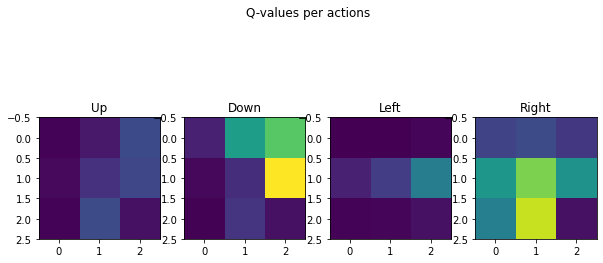

In [52]:
# Show update Q values
plt.subplots(1, 4, figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(Q_table["Up"].values.reshape(3, 3), vmin=Q_table.values.min(), vmax=Q_table.values.max())
plt.title("Up")
plt.subplot(1, 4, 2)
plt.imshow(Q_table["Down"].values.reshape(3, 3), vmin=Q_table.values.min(), vmax=Q_table.values.max())
plt.title("Down")
plt.subplot(1, 4, 3)
plt.imshow(Q_table["Left"].values.reshape(3, 3), vmin=Q_table.values.min(), vmax=Q_table.values.max())
plt.title("Left")
plt.subplot(1, 4, 4)
plt.imshow(Q_table["Right"].values.reshape(3, 3), vmin=Q_table.values.min(), vmax=Q_table.values.max())
plt.title("Right")
plt.suptitle("Q-values per actions")
plt.show()


The lighter colors show higher Q-values so for example, from middle right the
best choice now is going down; from middle bottom, we should go right; as
expected, going up or left has little value overall when we look for the
shortest path.


---


All of the methods we've seen up to this point are examples of reinforcement
learning. Unlike supervised learning, classification with SVMs or fitting
regression functions, we don't have an explicit target we are trying to predict
we don't have class values or a function we are trying to fit. It is also unlike
unsupervised learning, we have information about which outcomes are good and
bad, we are optimizing for something explicit.

The common theme among all these methods is we have some signal that indicates
how we are doing, we use this signal to learn about the environment we are
working in, and try and maximize our overall score.


## Deep Reinforcement Learning


Probably the most famous examples of reinforcement learning comes from learning
to play games. For example consider the game of Pong. Pong can be formulated as
a MDP. Let's say we wanted to train some model to control the left paddle. To
this model a state is just a picture of the screen:

<img src = "https://drive.google.com/uc?export=view&id=1ylg7XS4BlJym0pOYITQ2HDuFZZXWq_MN" width = 400 >
<center><i>(Image Source: <a>https://upload.wikimedia.org/wikipedia/commons/f/f8/Pong.png</a>)</i></center>

The actions are the the directions we can move our paddle (up, down or not at
all).

The objective is to maximize the score. We can't use traditional Q-Learning with
this problem since the number of possible states is huge. It would take forever
to converge to anything reasonable. Instead the standard technique is to now use
a neural network:

<img src = "https://drive.google.com/uc?export=view&id=1C_kEnG6gryrih4hJESiFR-welgUL5tc2" width=400>
<center><i>(Image Source: <a>https://i.imgur.com/0Cow9XW.png</a>)</i></center>

The network takes the state, represented as an image (or another appropriate
representation), and outputs an indication of which is the next best action.

This process is called Deep Q Learning, and is roughly divided into two main
categories:

#### Value-based Learning

Value based learning is appropriate for cases where the set of all possible
states is huge, but the set of all possible actions is finite and small. In
Value based learning, the network takes as input a state $S$ and outputs the
quality of all possible actions. If a given game has only four controls (e.g.
Up, Down, Left, Right), then the network outputs 4 qualities (the output layer
will have 4 neurons, but this is **NOT** a classification task): $Q(S, Up)$,
$Q(S, Down)$, $Q(S, Left)$, $Q(S, Right)$.

#### Policy-based Learning

Policy based learning tackles different games or situations where both the state
space and action space are very large. For these situations, given a possibility
of 40 actions, the network output layer will still have 40 output neurons.
However, it now becomes a classification problem. Formally speaking, given a
state $S$ we know want our network to learn $\pi(a_i|S)$, the probability of
action $a_i$ for state S.

Consider a game of chess. Instead of asking for the quality of each possible
action, we ask the network to output the probability every action should be
taken. Since this is rephrased as a classification task, we can make the network
run through experts' games at first, and learn some basic strategies (policies)
based on their games.


### But Games Don't Have Instant Rewards...

It's true. Consider again a game of chess. Perhaps we performed a set of
actions: <br>
$a_1 \rightarrow a_2 \rightarrow a_3 \rightarrow a_4 \rightarrow a_5 \rightarrow a_6 \rightarrow$
Lose

We can say all these actions are bad, and adjust our network to make sure it
won't repeat these actions given the states it saw. We can do this by storing
the sequence of actions in memory, then replay each of them, but associate them
with a bad reward, so that the probability of each won't get repeated.

However, we usually employ a more advanced approach where earlier actions in a
sequence which led to a lose get punished more lightly than later actions. This
makes sense since it's clear $a_6$ was a terrible action (it immediately led to
our loss) but it's not so obvious $a_1$ was bad because the rest of the game
might have unfolded differently.

This is not a perfect solution. Some games with multiple phases struggle with
this methodology, in general if it is not easy to get positive outcomes then our
network will have trouble learning what actions are good.


### (Almost) Optimal Chess

How do we put a good quality function together together? In the 1990s IBM Deep
Blue used a handcrafted quality function, built with the input of several chess
grand-masters. The function determined the quality of position by measuring
things like how safe the King was or how easy it would be to set up a common
attacking position. These values were fine tunned by watching the outcome of
various games between other grand-masters.

This wasn't very machine learning like, instead they just relied on human
knowledge and the ability of the computer to evaluate over 200 million board
positions a second. This type of strategy was enough to beat the world's best
(and probably any subsequent humans).


### (Almost) Optimal Go

Go is a much more complex game compared to chess. The problem is there are many
more nodes we need to evaluate. Using a similar strategy to Deep Blue computer
systems were able to defeat most amateur players, but could not compete with any
professionals.

<img src = "https://drive.google.com/uc?export=view&id=1ssbb4keuNdpJb-Vry9IE5_AJ64ww8pSW" width = 400>
<center><i>(Image Source: <a>https://upload.wikimedia.org/wikipedia/commons/2/2a/FloorGoban.JPG</a>)</i></center>

To beat Go players we need a better way of exploring the network and evaluating
states of the game. To do this, Google Alpha Go trained in three stages.

1. The network watched "replays" of expert Go players. It allowed it to learn
   that given some state $S$, the correct action (class) was $a_i$.
2. Once the network could copy humans players fairly well (it was making
   somewhat calculated moves instead of random moves), it was cloned and allowed
   to play against itself many times. Now it can play games and learn about the
   rewards of potentially different game styles, and it can do so much faster
   than any human could.
3. Another network, a "Value Network" studies the potential victories and losses
   from different states of the board as experienced by the Policy Network
   playing against itself, and works to output a single Q value for a given
   board. i.e. given a board state $S$, how good is that state? The use of that
   network comes when AlphaGo wants to look at potential states several actions
   in the future, but is able to quickly "prune" the search space by ignoring
   paths that entail bad states.

How we train these networks is pretty complex, and expensive. Some early
versions of Alpha Go trained on over 1500 CPUs and 200 GPUs.

Newer versions with smarter training and network structure, Alpha Zero, only
require 4 TPUs to train and uses no human input. Within a few days Alpha Zero
surpassed Alpha Go beating it 100 games to 0.


In [41]:
from IPython.display import IFrame

IFrame("https://www.youtube.com/embed/8tq1C8spV_g", width=560, height=315)
